### Applications in Root Cause Analysis : GLS

#### Overview

In this experiment, we demonstrate an application of partial ranking in High Performance Computing.

In general, a mathematical expression can have several (sometimes over 100s) alternative program implementations (or algorithms) that are mathematically equivalent to one another. Each alternative algorithm can be identified as a sequence of library or kernel calls provided by optimized libraries such as BLAS and LAPACK, and these algorithms can differ from one another in terms of performance. It is not straightforward for the developers to optimize such codes and ensure high performance. In this experiment, we demonstrate the application of the partial ranking methodologies in identifying the root cause of performance differences in terms of kernel calls.

To this end, let us consider the following Generalized Least Square (GLS) problem:

$(X^T M^{-1} X)^{-1} X^T M^{-1} y$ 

where $X \in \mathbb{R}^{1000 \times 100}$


We consider the algorithmic variants for solution of the GLS problem generated by the compiler [Linnea](https://github.com/HPAC/linnea).  Linnea takes as input the mathematical expression for GLS in a high-level format, as if written on a black-board, and generates top 100 algorithms (in terms of number of Floating Point Operations) in the Julia language. To explore some algorithms generated by Linnea, use the online demo through this [link](https://linnea.cs.umu.se/). 

#### The Data

We executed each of the 100 algorithms generated by Linnea 10 times on a Linux-based machine using 12 cores of an Intel-Xeon processor with turbo-boost enabled. We parsed the generated algorithms to identify the sequence of kernel calls, the corresponding number of Floating Point Operations (FLOPs), appended the execution times and saved the data in ``examples/data/gls_1000_100.csv``. The data is read into a Pandas DataFrame, preprocessed for readability, and presented below:

In [1]:
import pandas as pd

## Data preprocessing functions
def clean_concept(name):
    splits = name.split('=')
    if len(splits) > 1:
        return splits[-1].strip()
    return splits[0].strip()

def remove_cost(name):
    splits = name.split('_')
    if len(splits) > 1:
        return splits[0].strip()
    return splits[0].strip()

def remove_LAPACK(name):
    splits = name.split('.')
    if len(splits) > 1:
        return splits[-1].strip()
    return splits[0].strip()

df = pd.read_csv('data/gls_1000_100.csv',sep=';')
df['concept:name'] = df['concept:name'].apply(lambda row: clean_concept(row))
df['concept:name'] = df['concept:name'].apply(lambda row: remove_cost(row))
df['concept:name'] = df['concept:name'].apply(lambda row: remove_LAPACK(row))

#rename columns to meaningful names
df.rename(columns={
    'case:concept:name': 'algID_repID',
    'concept:name': 'kernel',
    'concept:flops': 'FLOPs',
    'concept:operation': 'operation',
    'concept:kernel': 'kernel_signature',
    'timestamp:start': 'timestamp:start',
    'timestamp:end': 'timestamp:end'
}, inplace=True)

df.head(10)

algID_repID kernel        FLOPs                operation  \
0  algorithm23_13  potrf  333000000.0            (L2 L2^T) = M   
1  algorithm23_13   trsm  100000000.0        tmp12 = (L2^-1 X)   
2  algorithm23_13   trsv    1000000.0        tmp68 = (L2^-1 y)   
3  algorithm23_13   gemv     200000.0  tmp21 = (tmp12^T tmp68)   
4  algorithm23_13   syrk   10000000.0  tmp14 = (tmp12^T tmp12)   
5  algorithm23_13     qr    2670000.0        (Q16 R17) = tmp14   
6  algorithm23_13   gemv      20000.0    tmp25 = (Q16^T tmp21)   
7  algorithm23_13   trsv      10000.0   tmp24 = (R17^-1 tmp25)   
8   algorithm1_19  potrf  333000000.0            (L2 L2^T) = M   
9   algorithm1_19   trsv    1000000.0        tmp68 = (L2^-1 y)   

                           kernel_signature  timestamp:start  timestamp:end  
0                   LAPACK.potrf!('L', ml1)     1.671793e+09   1.671793e+09  
1  trsm!('L', 'L', 'N', 'N', 1.0, ml1, ml0)     1.671793e+09   1.671793e+09  
2            trsv!('L', 'N', 'N', ml1, ml2)     1.671793e+09   1.671793e+09  
3       gemv!('T', 1.0, ml0, ml2, 0.0, ml3)     1.671793e+09   1.671793e+09  
4       syrk!('L', 'T', 1.0, ml0, 0.0, ml4)     1.671793e+09   1.671793e+09  
5                            ml4 = qr!(ml4)     1.671793e+09   1.671793e+09  
6       gemv!('T', 1.0, ml5, ml3, 0.0, ml6)     1.671793e+09   1.671793e+09  
7            trsv!('U', 'N', 'N', ml7, ml6)     1.671793e+09   1.671793e+09  
8                   LAPACK.potrf!('L', ml1)     1.671793e+09   1.671793e+09  
9            trsv!('L', 'N', 'N', ml1, ml2)     1.671793e+09   1.671793e+09

The column ``algID_repID`` represents the algorithm ID at a particular repetition. Single ``algID_repID`` is mapped to several BLAS kernels, whose sequence can be deduced from the timestamps. The total execution time of a particular repetition of an algorithm can be deduced by summing the duration of all the kernel calls based on the timestamps for that ``algID_repID``.

Out of the 100 algorithms, we consider only those algorithms whose average execution time was not more than 1.2x the average execution time of the algorithm with the fastest average execution time. This leaves us with the 10 algorithms shown below: 

In [2]:
short_list = ['algorithm2', 'algorithm8', 'algorithm17', 'algorithm53', 
            'algorithm54', 'algorithm58', 'algorithm62', 'algorithm66', 'algorithm99', 'algorithm88']

We consolidate the execution times of the shortlisted algorithms from all the repetitions and prepare the measurement data in the following format:

```
measurements = {
    'algorithm2': [0.025, 0.024, ..., ],
    'algorithm8': [0.023, 0.024, ..., ],
    ...
}
```

In [3]:
def get_trace_durations(event_table):
    """calculates duration of each case from event table"""
    dfs = event_table.drop_duplicates('algID_repID', keep='first')[['algID_repID', 'timestamp:start']]
    dfe = event_table.drop_duplicates('algID_repID', keep='last')[['algID_repID', 'timestamp:end']]
    dfm = dfs.merge(dfe, on='algID_repID')
    dfm['case:duration'] = dfm.apply(lambda row: row['timestamp:end'] - row['timestamp:start'], axis=1)
    dfm = dfm.rename(columns={
        'timestamp:start': 'case:timestamp:start',
        'timestamp:end': 'case:timestamp:end',
    })
    
    alg_list = [alg.split('_')[0] for alg in list(dfm['algID_repID'])]
    alg_list = list(set(alg_list))

    alg_measurements = {}
    for alg in alg_list:
        t_alg = dfm[dfm.apply( lambda x: x['algID_repID'].split('_')[0] == alg, axis=1)]
        alg_measurements[alg] = list(t_alg['case:duration'])
    return alg_measurements

df['case:variant'] = df['algID_repID'].apply(lambda row: row.split('_')[0])


df = df[df['case:variant'].isin(short_list)]

measurements = get_trace_durations(df)

The measurements are visualized using the ``partial_ranker.MeasurementsVisualizer`` module.

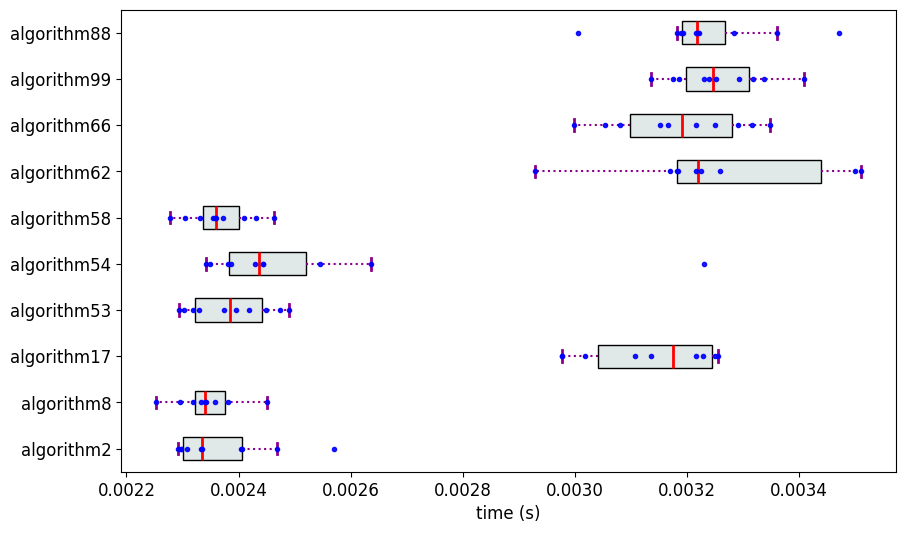

In [4]:
from partial_ranker import MeasurementsVisualizer

mv = MeasurementsVisualizer(measurements, short_list)
fig = mv.show_measurements_boxplots(scale=0.6)

In [17]:
## Rename algorithms for readability

# def rename_algs(alg_mes):
#     new_alg_mes = {}
#     l = [int(k.split('algorithm')[-1]) for k in list(alg_mes.keys())]
#     l.sort()
#     for i, alg in enumerate(l):
#         new_alg_mes['alg{}'.format(i)] = alg_mes['algorithm{}'.format(alg)].copy()
#     return new_alg_mes    
# new_alg_mes = rename_algs(measurements)
# alg_list = list(new_alg_mes.keys())
# mv = MeasurementsVisualizer(new_alg_mes, alg_list)
# fig = mv.show_measurements_boxplots(scale=0.6)
# fig.savefig("figures/gls-1000-100-box.svg", format="svg", bbox_inches="tight")

#### Partial Ranking of the Algorithms

We apply Methodology 2 (```partial_ranker.PartialRankerDFGReduced```) to rank the algorithms.

In [5]:
from partial_ranker import QuantileComparer
from partial_ranker import PartialRankerDFGReduced

comparer = QuantileComparer(measurements)
comparer.compute_quantiles(q_max=75, q_min=25,outliers=False)
comparer.compare()
pr_dfg = PartialRankerDFGReduced(comparer)
pr_dfg.compute_ranks()

R = pr_dfg.get_ranks()
for k,v in R.items():
    print(f'Rank {k}: {v}')

Rank 0: ['algorithm8', 'algorithm58', 'algorithm2', 'algorithm53', 'algorithm54']
Rank 1: ['algorithm99', 'algorithm88', 'algorithm66', 'algorithm62', 'algorithm17']


#### Mining for the Causes of Performance Differences in terms of Kernel Calls

**1. Identify the dependencies among the kernels:** We prepare a Directly-Follows Graph (DFG) where kernels are the nodes and an an edge from ``kernelA`` to ``kernelB`` exists if ``kernelA`` immediately follows ``kernelB`` in atleast one of the short-listed algorithms.

**2. Graph coloring**: We color the nodes and edges of the graph as follows:

- The nodes and edges that occur *only* in the algorithms with Rank 0 are indicated in *green*.  
- The nodes and edges that occur *only* in the algorithms with Rank 1 are indicated in *red*.
- The nodes and edges that occur *both* in the algorithms with Rank 0 and 1 are not colored.


**Requirements**:

To run the cells below, the following packages should be installed in the python environment:

```bash
#sudo apt-get install graphviz graphviz-devel
pip install pm4py
pip install pygraphviz
```

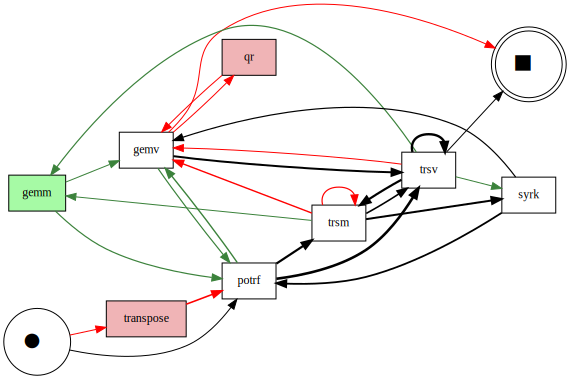

In [6]:
from pm4py.objects.conversion.log import converter as log_converter
from variants_compare import VariantsCompare

et = df.copy()
et.rename(columns={
    'algID_repID': 'case:concept:name',
    'kernel': 'concept:name',
}, inplace=True)
xes_log = log_converter.apply(et)

fast = R[0]
slow = R[1]

activity_key = 'concept:name'
vc = VariantsCompare(xes_log,fast,slow,activity_key=activity_key, variants_id_key="variant")
gviz = vc.get_dfg_minus_best_worst(orientation='LR')
gviz


In [7]:
gviz.render(filename='gviz/gls-1000-100-dfg', format='pdf')

'gviz/gls-1000-100-dfg.pdf'

**Inference**: It can be found that all the algorithms with Rank 0 use the kernel ``gemm``, which is a BLAS kernel for matrix-matrix multiplication, and the algorithms with Rank 1 do not use them. Instead the algorithms with Rank 1 solve the GLS problem through QR factorization. 

We do not identify this cause by coloring based on Top-1 or Top-K ranking methods. This motivates the need for partial ranking.


Top-1 Median

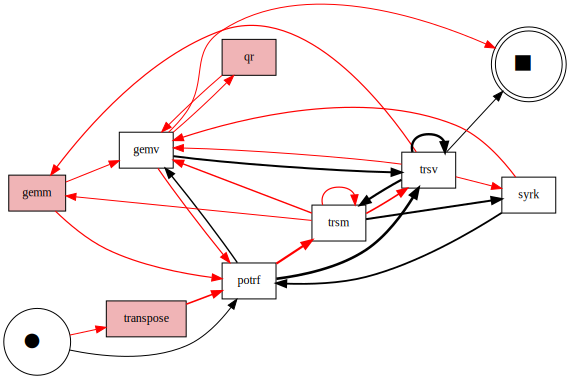

In [8]:
fast = ['algorithm2']
slow = ['algorithm8','algorithm17','algorithm53','algorithm54','algorithm58','algorithm62','algorithm66','algorithm99','algorithm88']
vc = VariantsCompare(xes_log,fast,slow,activity_key=activity_key, variants_id_key="variant")

gviz = vc.get_dfg_minus_best_worst(orientation='LR')
gviz

In [9]:
gviz.render(filename='figures/gls-median', format='pdf')

'figures/gls-median.pdf'

Top-4 Median

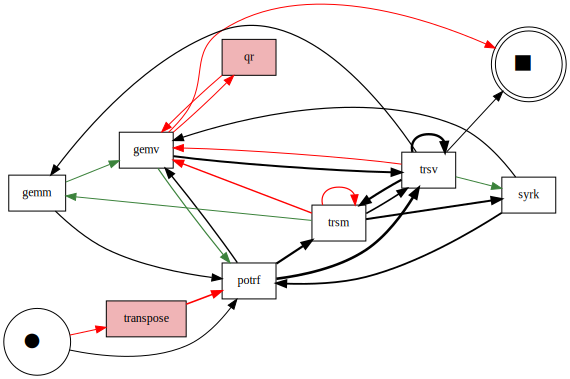

In [10]:
fast = ['algorithm8','algorithm2','algorithm53','algorithm58']
slow = ['algorithm17','algorithm54','algorithm62','algorithm66','algorithm99','algorithm88']
vc = VariantsCompare(xes_log,fast,slow,activity_key=activity_key, variants_id_key="variant")

gviz = vc.get_dfg_minus_best_worst(orientation='LR')
gviz

In [11]:
gviz.render(filename='figures/gls-top4', format='pdf')

'figures/gls-top4.pdf'